# Packages

In [9]:
import pandas as pd
import numpy as np
import os
from plotnine import *
from scipy.stats import pearsonr
from pingouin import intraclass_corr

# Data Read-in

In [2]:
combined_df = pd.read_csv("all_participants.csv")

# Graph All Participants (by Device and Motion)

In [3]:
def plot_all_device_data(df, motion_name, device_type='IMU'):
    """
    Plot all trials for one device type using ggplot style
    
    Args:
        df (pd.DataFrame):I nput dataframe containing motion capture data
        motion_name (str): Name of the motion ('axial', 'flexion', or 'lateral')
        device_type (str): 'IMU' or 'MoCap'
    """
    # Filter data for the specified movement and device
    plot_data = df[(df['movement'] == motion_name.lower()) & 
                   (df['device'].str.lower() == device_type.lower())].copy()
    
    # Convert trial numbers to strings for categorical plotting
    plot_data['participant'] = 'Participant ' + plot_data['participant'].astype(int).astype(str)
    
    plot = (
        ggplot(plot_data, aes(x='aligned_time', y='angle', color='participant')) +
        geom_line(size=1, alpha=0.7) +
        labs(
            title=f'{motion_name.capitalize()} - All {device_type} Participants',
            x='Aligned Time (s)',
            y='Angle (degrees)'
        ) +
        theme_bw() +
        theme(
            figure_size=(12, 6),
            legend_position='right',
            legend_title=element_blank()
        )
    )
    return plot

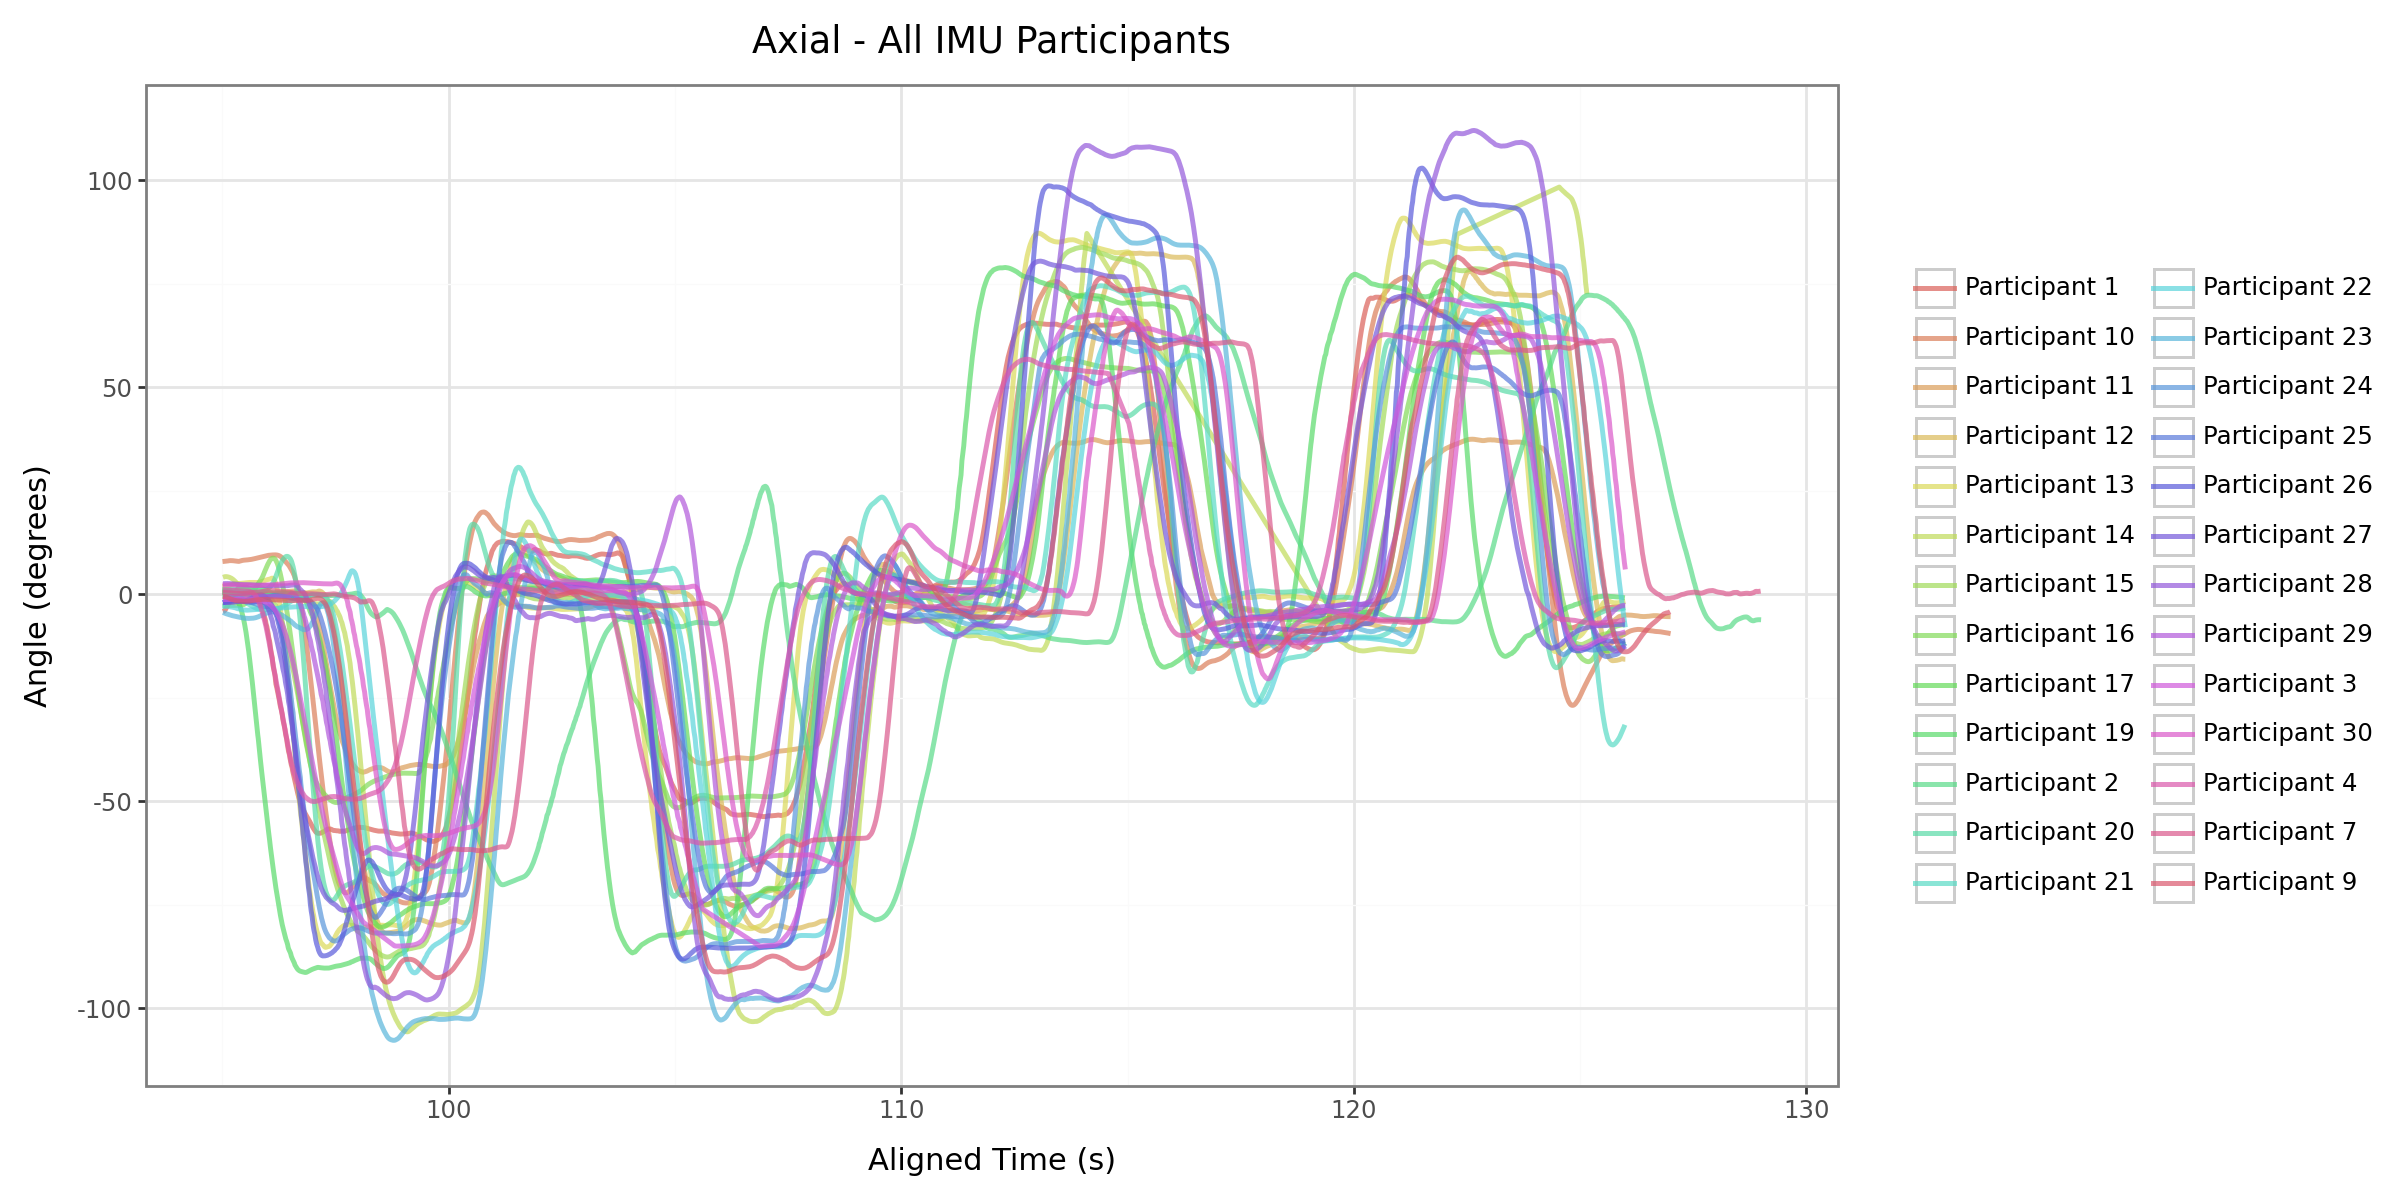

In [4]:
plot = plot_all_device_data(combined_df, motion_name='axial', device_type='IMU')
plot.show()

plot = plot_all_device_data(combined_df, motion_name='axial', device_type='MoCap')
# plot.show()

# Graph Individual Participant Plots (by Motion)

In [5]:
def plot_single_trial(df, motion_name, participant_num, 
                     gap_threshold=0.15,
                     highlight_thresholds=None,
                     highlight_color='red',
                     highlight_alpha=0.1):
    """
    Plots IMU and MoCap angle data for a single trial with optional threshold highlighting.
    
    Args:
        df (pd.DataFrame): Input dataframe containing motion capture data
        motion_name (str): Name of the movement to plot (e.g., 'axial', 'lateral')
        participant_num (float): Participant number to plot
        gap_threshold (float, optional): Time difference (seconds) that indicates a gap in data. 
                                        Points with larger time differences will be disconnected.
                                        Defaults to 0.15.
        highlight_thresholds (tuple, optional): (lower, upper) thresholds for highlighting.
                                              If provided, values beyond these thresholds will be shaded.
                                              Defaults to None.
        highlight_color (str, optional): Color for threshold highlighting. Defaults to 'red'.
        highlight_alpha (float, optional): Transparency for threshold highlighting. Defaults to 0.1.
    """
    # Filter data for the specific trial and movement
    trial_data = df[(df['participant'] == participant_num) & 
                   (df['movement'] == motion_name.lower())].copy()
    
    if trial_data.empty:
        raise ValueError(f"Participant {participant_num} not found for movement {motion_name}")
    
    # Sort by time and add gap indicators
    trial_data = trial_data.sort_values('aligned_time')
    trial_data['time_diff'] = trial_data['aligned_time'].diff()
    trial_data['new_group'] = (trial_data['time_diff'] > gap_threshold).cumsum()
    
    # Pivot to wide format for plotting both devices
    plot_df = trial_data.pivot_table(
        index=['aligned_time', 'new_group'],
        columns='device',
        values='angle',
        aggfunc='first'
    ).reset_index()
    
    # Clean device names to match original format
    plot_df.columns.name = None
    plot_df = plot_df.rename(columns={
        'imu': 'Angle IMU (degrees)',
        'mocap': 'Angle MoCap (degrees)'
    })
    
    # Base plot
    plot = (
        ggplot(plot_df, aes(x='aligned_time')) +
        geom_line(aes(y='Angle IMU (degrees)', color='"IMU"', group='new_group'), size=0.85) +
        geom_line(aes(y='Angle MoCap (degrees)', color='"MoCap"', group='new_group'), size=0.85) +
        labs(title=f'{motion_name.capitalize()} - Participant {participant_num}') +
        scale_color_manual(values=["blue", "green"]) +
        theme_bw() +
        theme(figure_size=(12, 6))
    )
    
    # Add threshold highlighting if requested
    if highlight_thresholds:
        lower, upper = highlight_thresholds
        
        # Create highlight regions
        highlight_df = pd.DataFrame({
            'xmin': plot_df['aligned_time'] - 0.005,
            'xmax': plot_df['aligned_time'] + 0.005,
            'ymin_upper': upper,
            'ymin_lower': -np.inf,
            'ymax_upper': np.inf,
            'ymax_lower': lower,
            'upper_highlight': (plot_df['Angle IMU (degrees)'] > upper) | (plot_df['Angle MoCap (degrees)'] > upper),
            'lower_highlight': (plot_df['Angle IMU (degrees)'] < lower) | (plot_df['Angle MoCap (degrees)'] < lower)
        })
        
        # Upper threshold highlights
        plot += geom_rect(
            data=highlight_df[highlight_df['upper_highlight']],
            mapping=aes(
                xmin='xmin',
                xmax='xmax',
                ymin='ymin_upper',
                ymax='ymax_upper'
            ),
            fill=highlight_color,
            alpha=highlight_alpha,
            inherit_aes=False
        )
        
        # Lower threshold highlights
        plot += geom_rect(
            data=highlight_df[highlight_df['lower_highlight']],
            mapping=aes(
                xmin='xmin', 
                xmax='xmax', 
                ymin='ymin_lower', 
                ymax='ymax_lower'
            ),
            fill=highlight_color,
            alpha=highlight_alpha,
            inherit_aes=False
        )
        
        # Threshold reference lines
        plot += geom_hline(yintercept=upper, linetype='dashed', color='black', alpha=0.5)
        plot += geom_hline(yintercept=lower, linetype='dashed', color='black', alpha=0.5)
        
    plot += labs(
        x='Aligned Time (s)',
        y='Angle (degrees)',
        color='Device'
    )
    
    return plot

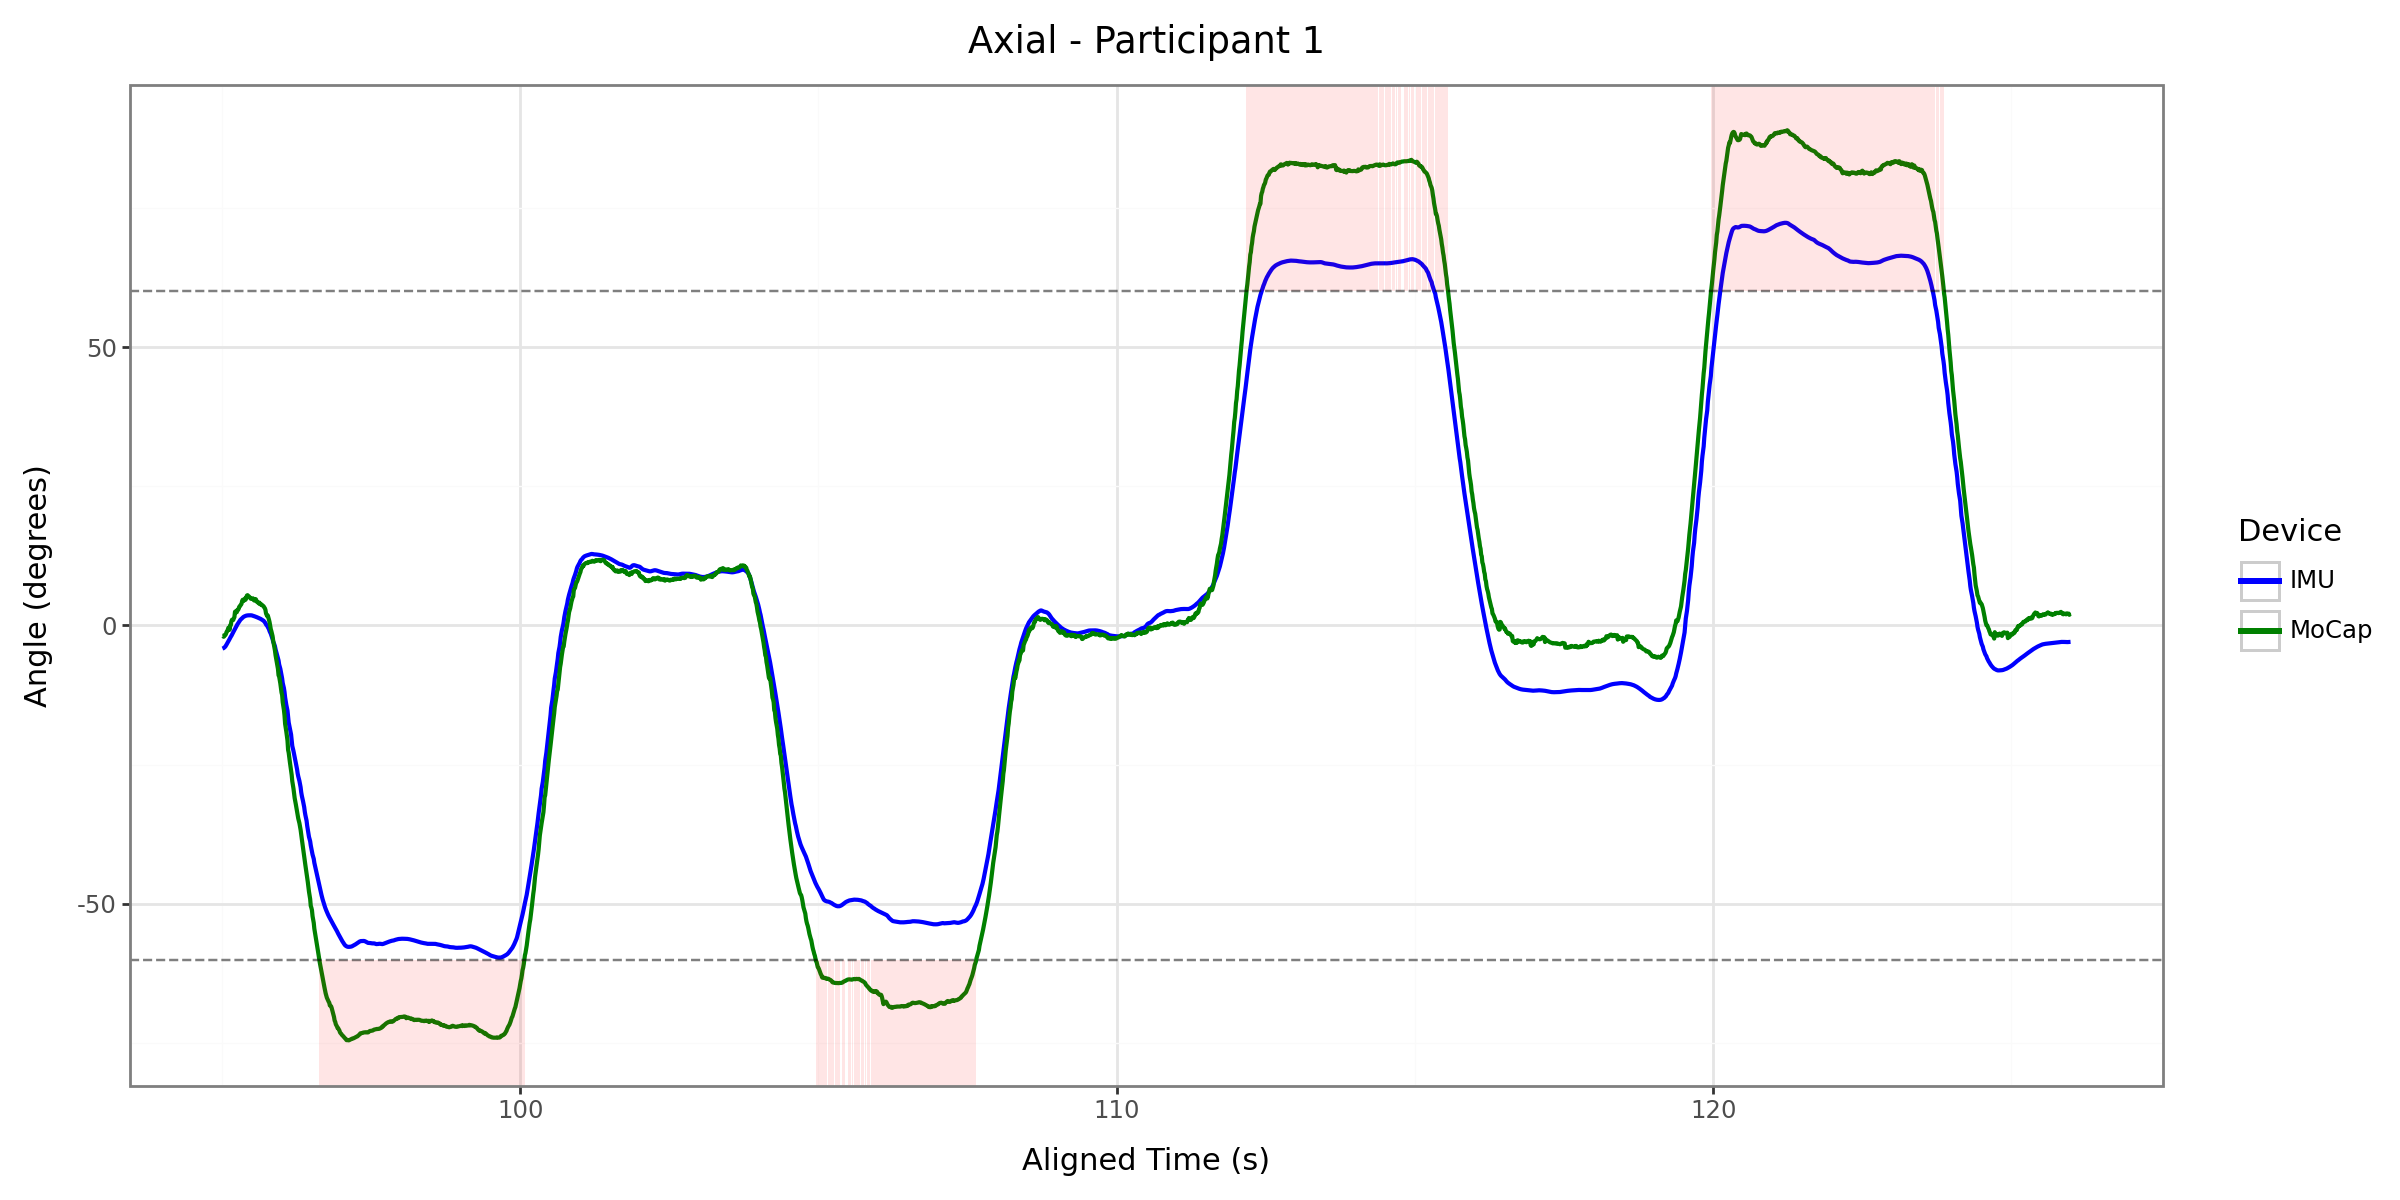

In [6]:
plot = plot_single_trial(combined_df, 'axial', 1, highlight_thresholds=(-60, 60))
plot.show()

plot = plot_single_trial(combined_df, 'flexion', 1, highlight_thresholds=(-60, 60))
# plot.show()

plot = plot_single_trial(combined_df, 'lateral', 1, highlight_thresholds=(-60, 60))
# plot.show()

# Graph Differnce Plots (MoCap - IMU; by Motion)

In [31]:
def plot_differences(df, motion_name, smooth=True):
    """
    Plots the differences between MoCap and IMU angle measurements with optional smoothing.
    Includes individual participant correlations and ICC in the title.
    
    Args:
        df (pd.DataFrame): Input dataframe in long format with columns:
            - participant: participant ID
            - movement: movement type
            - aligned_time: time points
            - device: 'imu' or 'mocap'
            - angle: measured angle
        motion_name (str): Name of the movement to plot (e.g., 'axial', 'lateral')
        smooth (bool, optional): Whether to add an overall smoothing spline. Defaults to True.
    """
    # Filter data for the specified movement
    movement_data = df[df['movement'] == motion_name.lower()].copy()
    
    if movement_data.empty:
        raise ValueError(f"No data found for movement {motion_name}")
    
    # Pivot to wide format for analysis
    wide_df = movement_data.pivot_table(
        index=['participant', 'aligned_time'],
        columns='device',
        values='angle',
        aggfunc='first'
    ).reset_index()
    
    # Calculate differences
    wide_df['Difference'] = wide_df['mocap'] - wide_df['imu']
    wide_df['Participant'] = 'Participant ' + wide_df['participant'].astype(int).astype(str)
    
    # Calculate individual participant correlations
    corr_results = []
    for pid in wide_df['participant'].unique():
        subset = wide_df[wide_df['participant'] == pid]
        r, _ = pearsonr(subset['mocap'].dropna(), subset['imu'].dropna())
        corr_results.append({'participant': pid, 'correlation': r})
    
    participant_corrs = pd.DataFrame(corr_results)
    mean_corr = participant_corrs['correlation'].mean()
    
    # Prepare data for ICC (need long format with all measurements)
    icc_data = movement_data[['participant', 'aligned_time', 'device', 'angle']].copy()
    icc = intraclass_corr(
        data=icc_data,
        targets='participant',  # participants are the "targets"
        raters='device',        # devices are the "raters"
        ratings='angle'
    )
    # Get ICC2k (two-way random, absolute agreement, average measures)
    icc_value = icc.loc[icc['Type'] == 'ICC2k', 'ICC'].values[0]
    
    # Create correlation text for plot
    corr_text = (f"Mean r = {mean_corr:.3f} (range: {participant_corrs['correlation'].min():.3f}-"
                f"{participant_corrs['correlation'].max():.3f}), ICC2k = {icc_value:.3f}")
    
    # Base plot
    plot = (
        ggplot(wide_df, aes(x='aligned_time', y='Difference')) +
        geom_hline(yintercept=0, linetype='dashed', color='gray', alpha=0.5) +
        labs(
            title=f'{motion_name.capitalize()} - MoCap vs IMU Differences\n{corr_text}',
            x='Aligned Time (s)',
            y='Difference (degrees)'
        ) +
        theme_bw() +
        theme(figure_size=(12, 6), plot_title=element_text(size=10))
    )
    
    if not smooth:
        # Individual trial lines with colors
        plot += geom_line(aes(color='Participant'), size=.85, alpha=0.5)
    else:
        # Faint individual lines
        plot += geom_line(aes(group='Participant'), color='gray', size=.85, alpha=0.15)
    
    if smooth:
        plot += geom_smooth(
            aes(group=1),
            method='loess',
            color='red',
            size=1.5,
            alpha=0.8,
            span=0.3,
            se=False
        )
    
    return plot

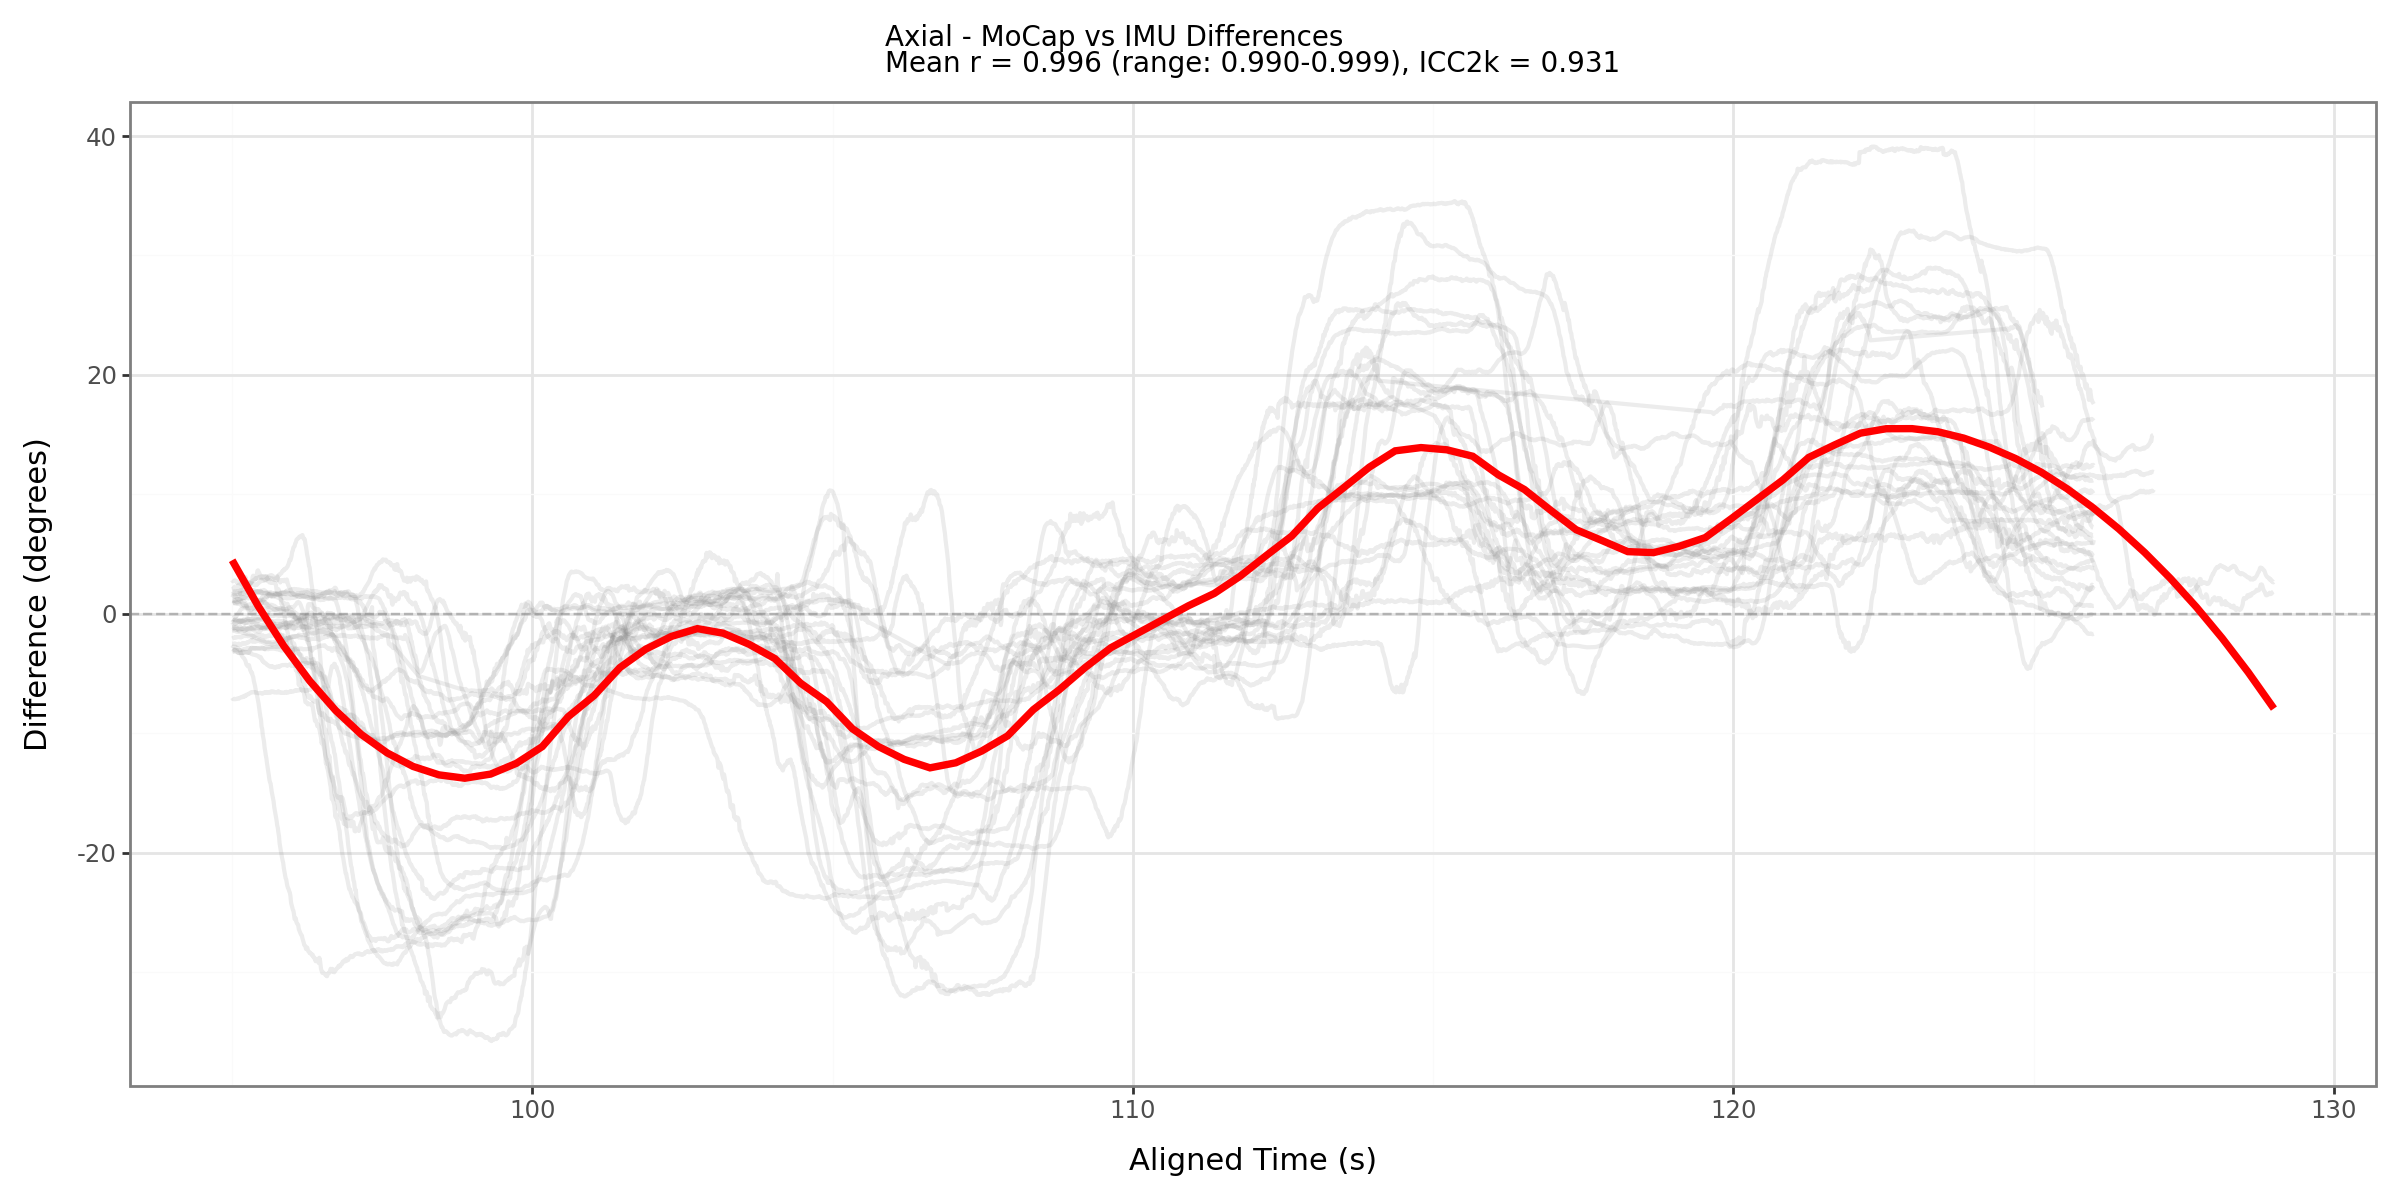

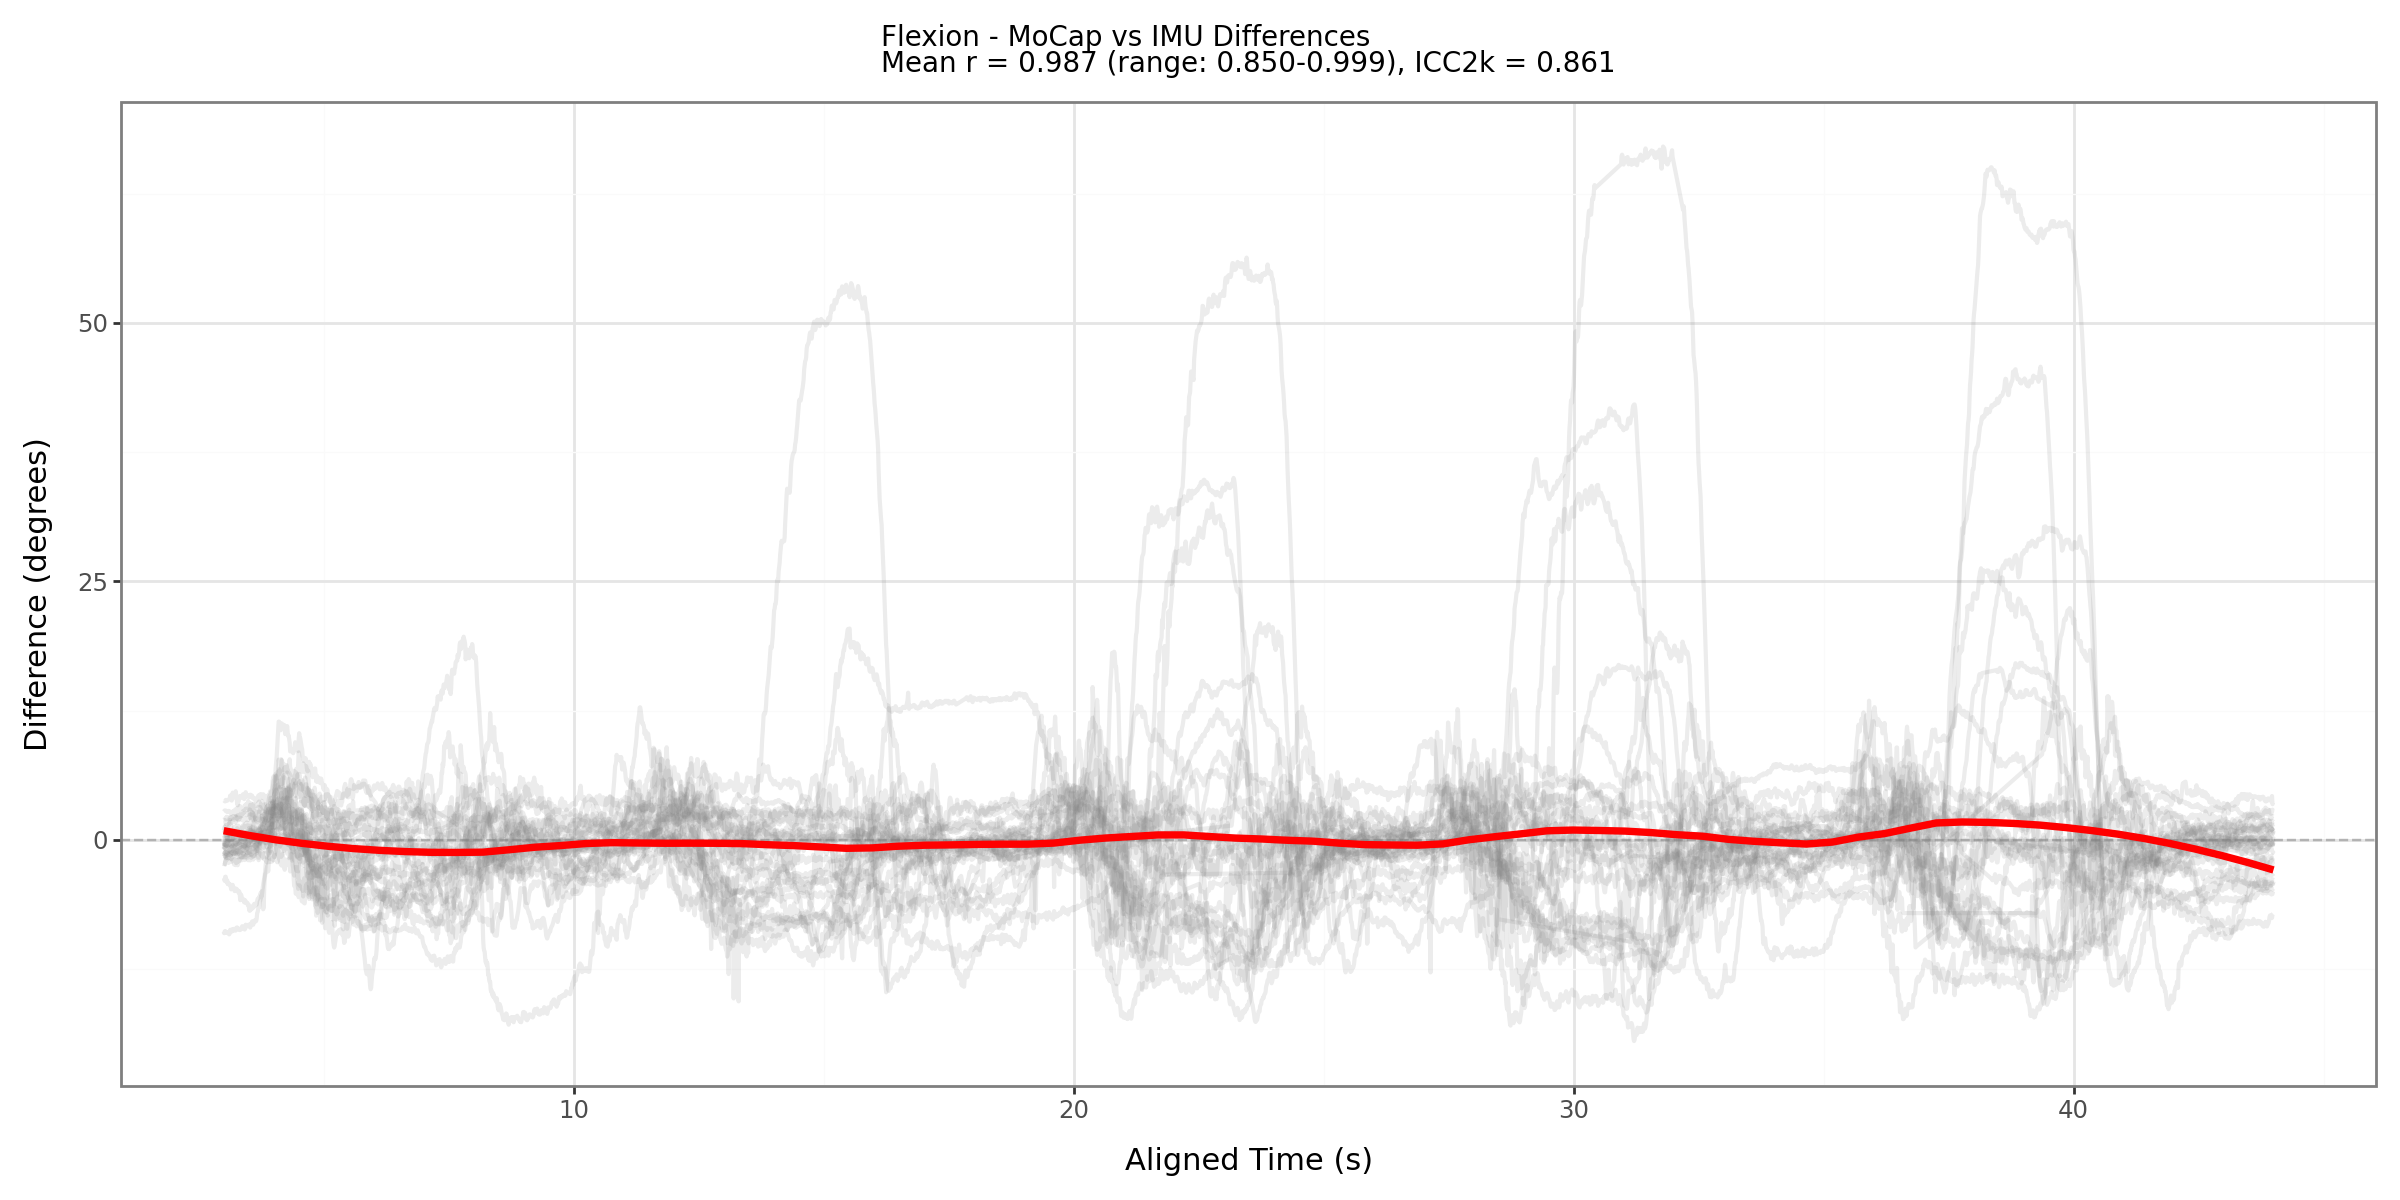

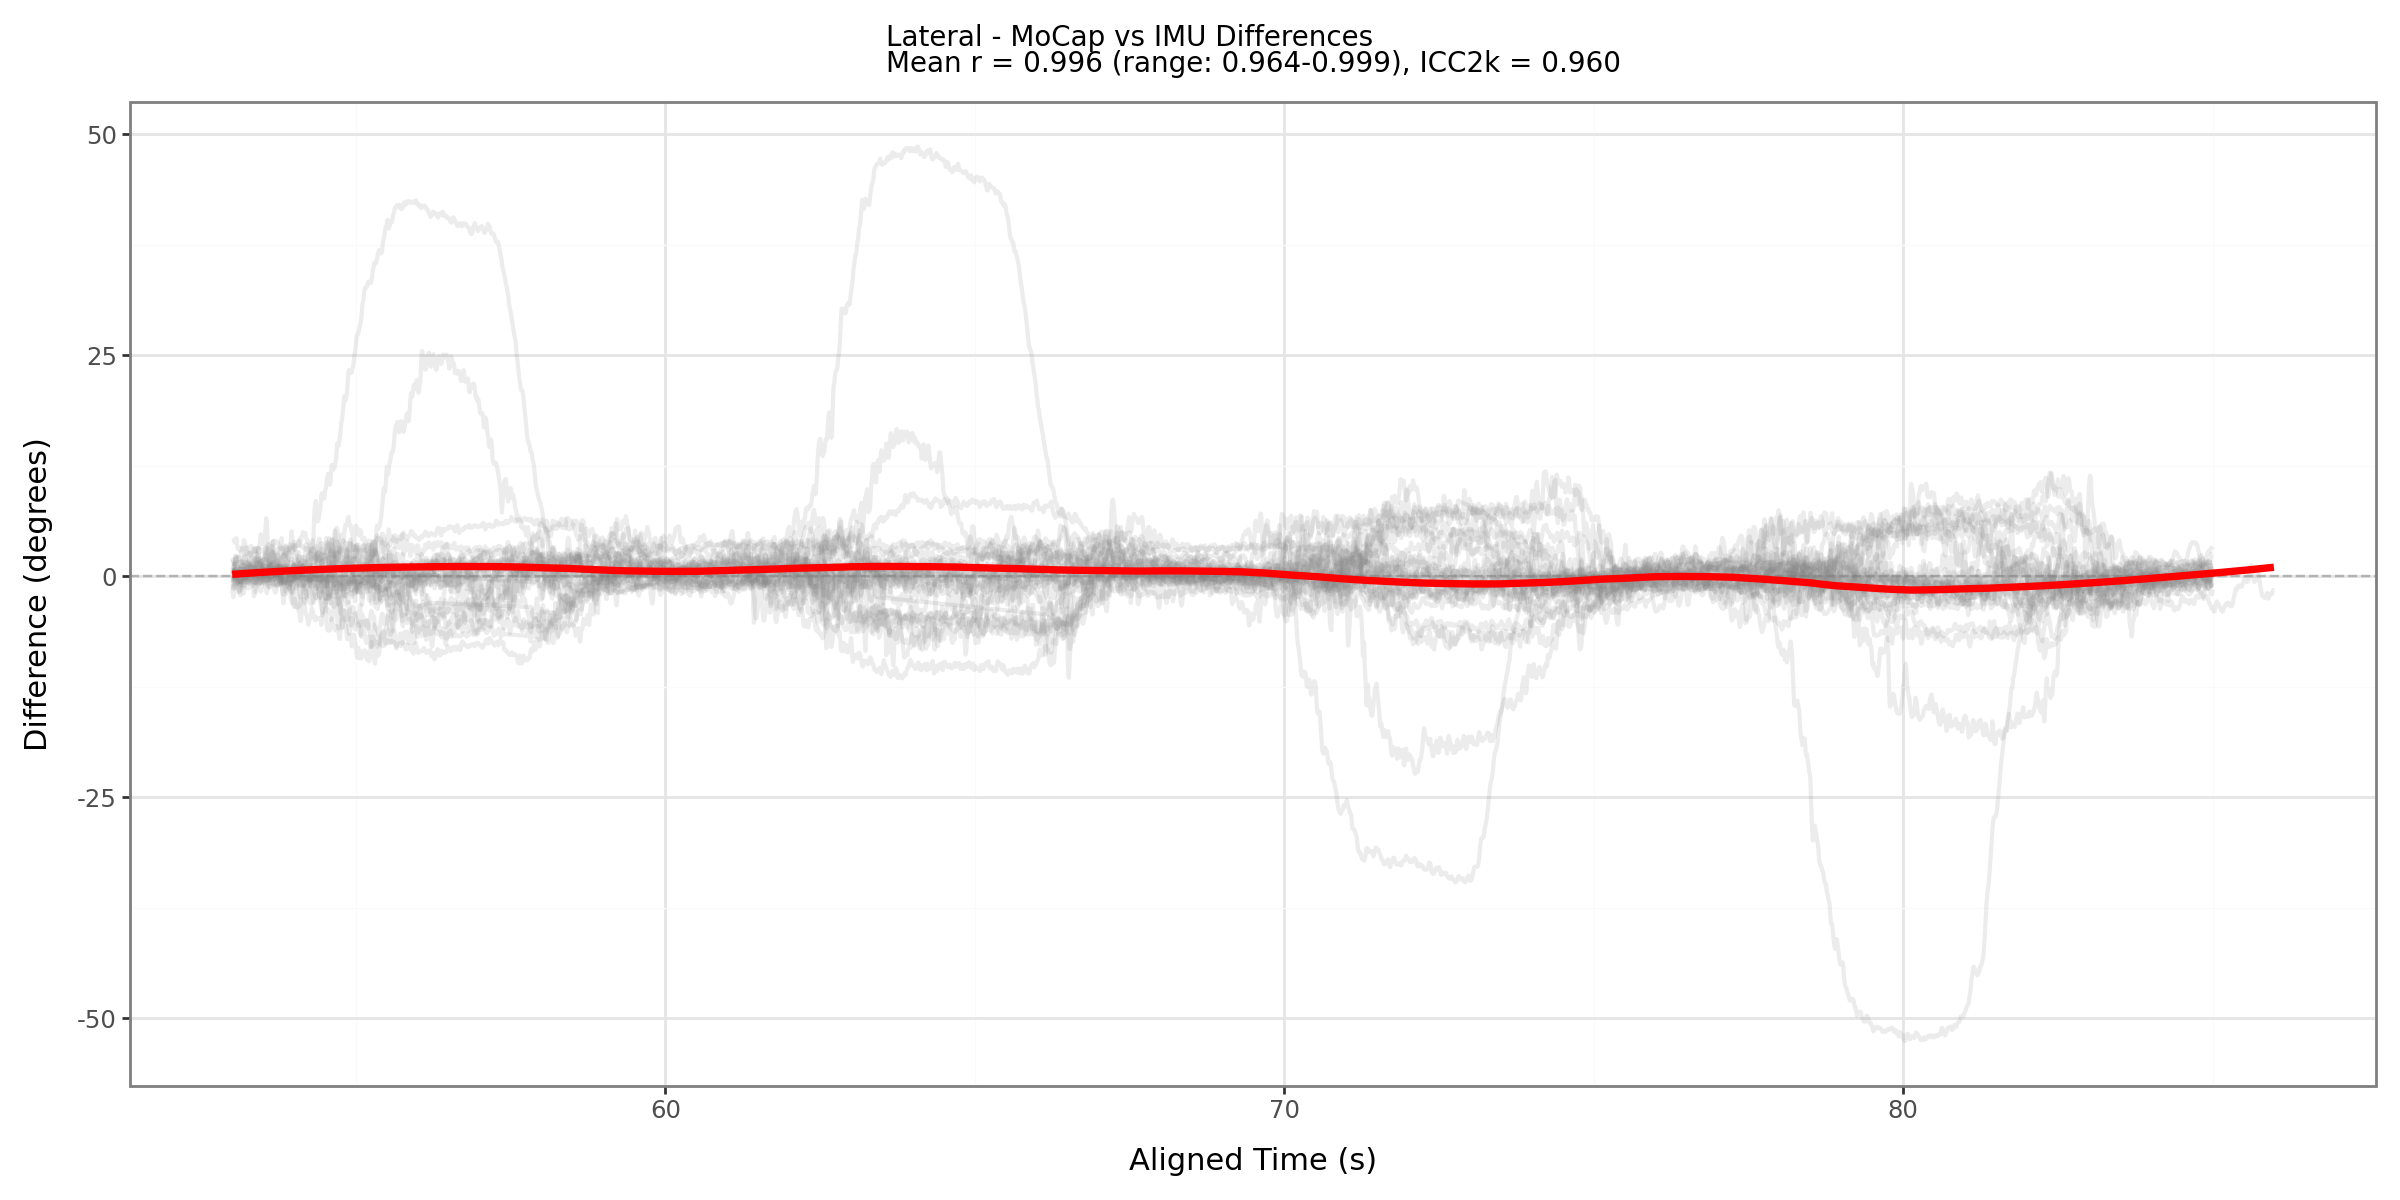

In [33]:
p = plot_differences(combined_df, 'axial', smooth=False)
# p.show()

p = plot_differences(combined_df, 'axial', smooth=True)
p.show()

p = plot_differences(combined_df, 'flexion', smooth=True)
p.show()

p = plot_differences(combined_df, 'lateral', smooth=True)
p.show()

## What is r and ICC?

### Pearson's R (Correlation Coefficient)

What it is:

- Measures how closely two measurements (IMU and MoCap) move together

- Ranges from -1 to 1:

    + 1 = Perfect match (when IMU goes up, MoCap goes up exactly the same)

    + 0 = No relationship

    + -1 = Perfect opposite (when IMU goes up, MoCap goes down)

What it tells us:

- "Do these two devices generally agree on the pattern of movement?"

- Example: If Pearson's R is 0.9 → Very strong agreement in the trends of motion

Limitation:

- Only checks if patterns match, not if actual numbers agree

- Two devices could give different numbers but still have high R if they move similarly

### ICC (Intraclass Correlation Coefficient)

What it is:

- Measures how identical measurements are (not just patterns)

- Ranges from 0 to 1:

    + 1 = Perfect agreement (IMU and MoCap give the exact same numbers)

    + 0 = No agreement

What it tells us:

- "Can these two devices be used interchangeably?"

- Example: ICC of 0.8 → Strong agreement in actual values

### Why ICC2k?

We chose ICC2k ("two-way random, absolute agreement, average measures") because:

- "Two-way random" → Both devices are treated as random samples (we’re not just testing these specific IMU/MoCap units but these devices in general).

- "Absolute agreement" → We care if numbers match exactly (not just move similarly).

- "Average measures" → We’re comparing averages over time (not single time points).

Analogy:

- Pearson’s R tells you if two thermometers rise/fall together in a room.

- ICC tells you if they show the same temperature number at any given time.

- ICC2k is checking if any two thermometers (not just these two) would agree in any room.